In [1]:
import numpy as np
import matplotlib .pyplot as plt 
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
keras.backend.set_floatx('float16')
keras.backend.set_epsilon(1e-12)

import io
import imageio
from IPython.display import display
from ipywidgets import widgets, HBox

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


### Download del dataset

In [2]:
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

#### Scambio assi per compatibilita con keras(HWC) 
#### Prendo i primi 1000 elementi del dataset
#### Aumento la dimensionalita delle immagini perche non hanno canale essendo in bianco e nero 

In [3]:
dataset = np.swapaxes(dataset, 0, 1)

dataset = dataset[:1000] 

dataset = np.expand_dims(dataset, axis= -1)

#### divisione del dataset in train e validation

In [4]:
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]):]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

#### Normalizzazione

In [5]:
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

#### Funzione per creazione del dataset di addestramento e di validazione

In [6]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

#### Visualizzazione dati

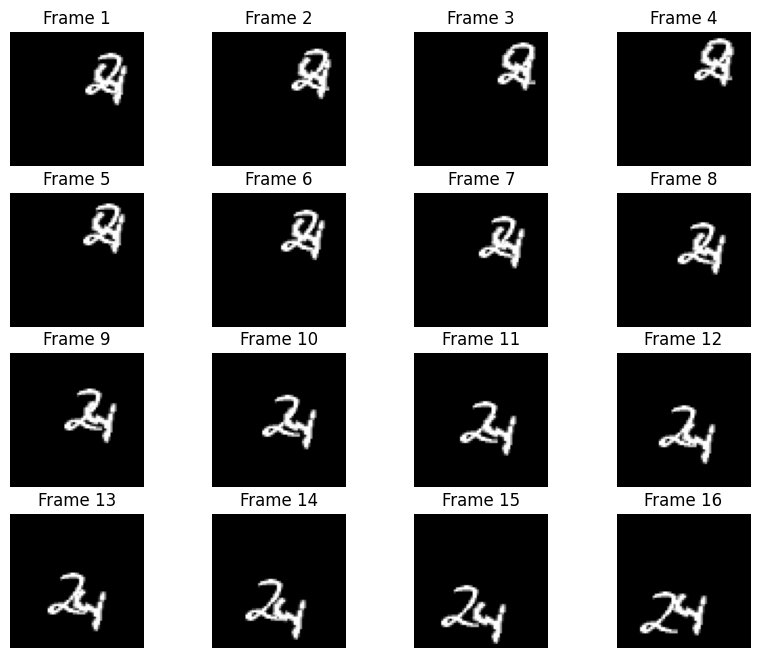

In [7]:
fig, axes = plt.subplots(4, 4, figsize= (10,8))

data_choice = np.random.choice(range(len(train_dataset)), size =1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(train_dataset[data_choice][idx], cmap = 'gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

plt.show()

#### Scrittura di un architettura con ConLSTM che accetti un input di frame variabile e compilazione del modello

In [8]:
inp = layers.Input(shape = (None, * x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters= 128,
    kernel_size = 5,
    padding = 'same',
    return_sequences = True,
    activation = 'swish',)(inp)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 128,
    kernel_size = 3,
    padding = 'same',
    return_sequences = True,
    activation = 'swish',)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size = 1,
    padding = 'same',
    return_sequences = True,
    activation = 'swish',)(x)
x = layers.Conv3D(filters=1, kernel_size= (3, 3, 3,), activation = 'sigmoid', padding= 'same')(x) 


model = keras.models.Model(inp, x)
legacy_optimizer = tf.keras.optimizers.legacy.Adam()

model.compile(optimizer=legacy_optimizer, loss=keras.losses.binary_crossentropy)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 12   1651712   
                             8)                                  
                                                                 
 batch_normalization (Batch  (None, None, 64, 64, 12   512       
 Normalization)              8)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 12   1180160   
                             8)                                  
                                                                 
 batch_normalization_1 (Bat  (None, None, 64, 64, 12   512   

#### Addestramento del modello con definizioni callbacks

In [9]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 100
batch_size = 12

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

In [10]:
model.load_weights('weights/backup')

#### selezione esempi casuli nel dataset e creazione delle predizioni

In [11]:

example = val_dataset[np.random.choice(range(len(val_dataset)), size= 1 )[0]]

frames = example[:10, ...]
original_frames = example[10:, ...]

for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0) 
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)



1/1 [==============================] - 12s 12s/step


#### Costruzione del grafico per la visualizzazione della sequenza originale e di quella predetta dal modello 

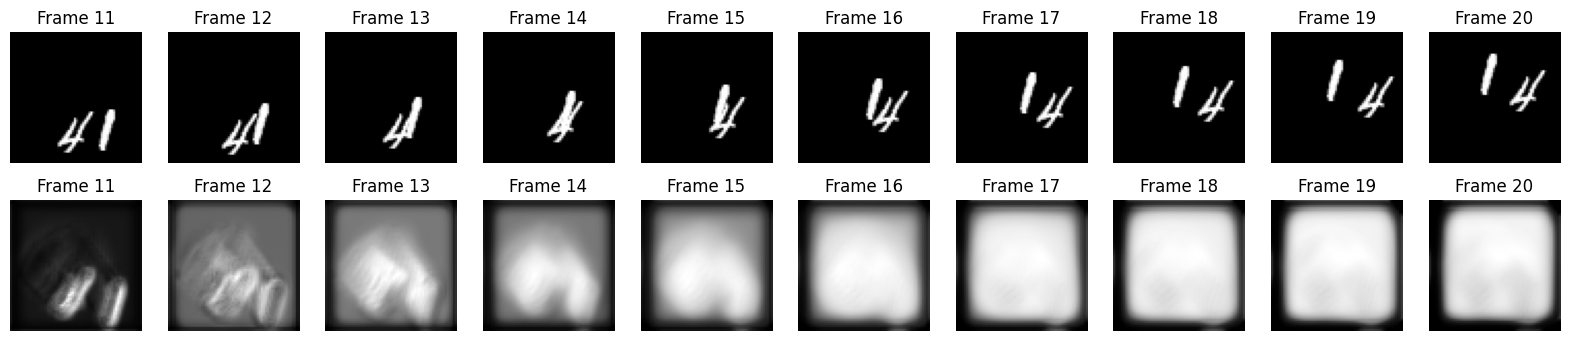

In [12]:
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

#### Costruisco delle GIF con i valori di train e con i valori predetti

In [16]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set) 
        current_frames = current_frames[..., np.newaxis] * np.ones(3) 
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=1 / 5, loop=0)
            predicted_videos.append(gif.getvalue())

print("  Truth Prediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 13s 13s/step
  Truth Prediction
